In [ ]:
import os
import glob
import torch
import torch.nn as nn
from torchvision.io import read_image

In [ ]:
def file_name_to_label(file_name):
    return file_name.split('_')[-1].split('.')[0]

labels_map = {
    '0': 0,
    'k': 1,
    'q': 2,
    'r': 3,
    'b': 4,
    'n': 5,
    'p': 6,
    'K': 7,
    'Q': 8,
    'R': 9,
    'B': 10,
    'N': 11,
    'P': 12
}

class ChessDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None, target_transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.files = glob.glob(f'{data_dir}/*')
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        file_name = os.path.basename(file_path)
        image = read_image(file_path)
        label = labels_map[file_name_to_label(file_name)]
        
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms


In [84]:
my_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

target_transforms = transforms.Lambda(lambda y: torch.zeros(13, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

train_dataset = ChessDataset('another/dataset/mixed_train_squares', transform=my_transforms, target_transform=target_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ChessDataset('another/dataset/mixed_test_squares', transform=my_transforms, target_transform=target_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [85]:
print(len(train_dataset))
print(len(test_dataset))

13017
60


In [ ]:
class ChessCNN(nn.Module):
    def __init__(self):
        super(ChessCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(10816, 64)
        self.fc2 = nn.Linear(64, 13)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, 0.2, self.training)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda:0")
model = ChessCNN().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

In [ ]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{10}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    # Test the model every epoch
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the test images: {acc} %')
    

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

device = torch.device("cuda:0")
# Check on wich images the model fails
failed_imgages = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

        for i in range(len(labels)):
            if predicted[i] != torch.argmax(labels, dim=1)[i]:
                print(f'Predicted: {predicted[i]}, actual: {torch.argmax(labels, dim=1)[i]}')
                failed_imgages.append(images[i])


Predicted: 1, actual: 0
Predicted: 4, actual: 10
Predicted: 8, actual: 0
Predicted: 12, actual: 0


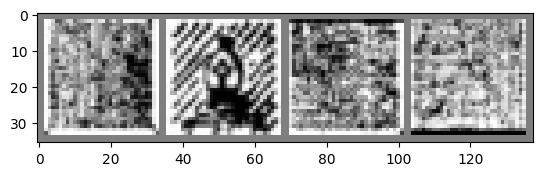

In [108]:
import torchvision

# Copy images to the host
failed_imgages = [img.cpu() for img in failed_imgages]

# show images
imshow(torchvision.utils.make_grid(failed_imgages))

In [ ]:
# Save the model pth
torch.save(model, 'model85.pth')